# Telco Churn Classification Project

___________________________________

## Business Goals:
- Find a driver of churn for Telco customers
- Construct a ML classification model that accurately predicts customer churn.
- Document your process well enough to be presented or read like a report

____________________________

## Project Planning:
1. Create README.md with data dictionary, project and businesss goals, create inital hypothesis
2. Acquire data from the Codeup Database and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
3. Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
4. Clearly define two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
5. Establish a baseline accuracy and document well.
6. Train three different classification models.
7. Evaluate models on train and validate datasets.
8. Choose the model with that performs the best and evaluate that single model on the test dataset.
9. Create csv file with the customer id, the probability of the target values, and the model's prediction for each observation in my test dataset.
10. Document conclusions, takeaways, and next steps in the Final Report Notebook.

______________________________

## Executive Summary- Conclusions and Next Steps:
- My findings are:
    - I will be using the decision tree model as my best model for prediction my target value, churn because:
        - there is an accuracy of 79.36% on both the train set and 78.95% on the validate set
        - this model outperformed my baseline score of 73.12%
        - there is not a large drop off of accuracy between the two sets (thus it is not overfit)

_________________________

In [1]:
#import needed libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pydataset import data

#import ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
from sklearn.model_selection import train_test_split #train, test, split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Acquire

Plan --- **Acquire** --- Prepare --- Explore --- Model --- Deliver

In [3]:
# acquire
from env import host, user, password
import acquire

In [4]:
# Create helper function to get the necessary connection url.

def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [5]:
#acquire function
def get_telco_churn_data():
    '''
    This function reads in the iris data from the Codeup db
    and returns a pandas DataFrame with all columns.
    '''
    
    sql_query = '''
    SELECT *
    FROM customers
    JOIN contract_types ON customers.contract_type_id = contract_types.contract_type_id
    JOIN payment_types ON customers.payment_type_id = payment_types.payment_type_id
    JOIN internet_service_types ON customers.internet_service_type_id = internet_service_types.internet_service_type_id
    '''
    return pd.read_sql(sql_query, get_connection('telco_churn'))

In [6]:
# call acquire function and take a look
df = get_telco_churn_data()

In [7]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,payment_type_id,payment_type,internet_service_type_id,internet_service_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,Yes,...,2,90.45,5957.9,No,3,Two year,2,Mailed check,1,DSL
1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,Yes,...,4,45.20,2460.55,No,3,Two year,4,Credit card (automatic),1,DSL
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,Yes,...,3,45.05,2560.1,No,3,Two year,3,Bank transfer (automatic),1,DSL
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,Yes,...,4,39.40,825.4,No,3,Two year,4,Credit card (automatic),1,DSL
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,No,...,3,85.15,6316.2,No,3,Two year,3,Bank transfer (automatic),1,DSL


## Takeaways of the Acquire process:
- I wrote a SQL query to create the acquire function
- I joined 3 tables together to get all data needed


<hr style="border:2px solid black"> </hr>

# Prepare

Plan --- Acquire --- **Prepare** --- Explore --- Model --- Deliver

In [8]:
# import prepare

In [9]:
def prep_telco_churn(df):
    '''
    This function takes in the telco_churn df acquired by get_telco_churn_data
    Returns the telco_churn df.
    '''
    # drop duplicate columns from join
    df = df.loc[:, ~df.columns.duplicated()]
    
    # change data types
    df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)
    df.replace({'churn': {'No':0, 'Yes':1}}, inplace=True)
    
    #drop duplicates
    df.drop_duplicates(inplace=True)

    #create dummies
    dummy_df = pd.get_dummies(df[['internet_service_type_id','contract_type_id']], dummy_na = False, drop_first=[True,True])
    #concat dummies with original df
    df= pd.concat([df, dummy_df], axis=1)

    return df

In [10]:
#reassign prep_telco_churn(df) to just df
df = prep_telco_churn(df)

In [11]:
#call df and look at it
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,internet_service_type_id,contract_type_id
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,Yes,...,Yes,2,90.45,5957.90,0,Two year,Mailed check,DSL,1,3
1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,Yes,...,No,4,45.20,2460.55,0,Two year,Credit card (automatic),DSL,1,3
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,Yes,...,No,3,45.05,2560.10,0,Two year,Bank transfer (automatic),DSL,1,3
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,Yes,...,Yes,4,39.40,825.40,0,Two year,Credit card (automatic),DSL,1,3
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,No,...,Yes,3,85.15,6316.20,0,Two year,Bank transfer (automatic),DSL,1,3


In [72]:
#split data
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [74]:
print(f'train shape: {train.shape}')
print(f'validate shape: {validate.shape}')
print(f'test shape: {test.shape}')

train shape: (3943, 26)
validate shape: (1691, 26)
test shape: (1409, 26)


## Takeaways of the Prepare process:

- prep_telco_churn(df) function was created to:
    - change data types 
    - remove duplicates (if any) 
    - create dummy columns
    - concatinate those dummy columns with the original dataframe
- "prep_telco_churn(df)" was then renamed to "df"


<hr style="border:2px solid black"> </hr>

# Explore

Plan --- Acquire --- Prepare --- **Explore** --- Model --- Deliver

In [76]:
#take a look at the data
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,internet_service_type_id,contract_type_id
4604,5564-NEMQO,Female,1,No,No,1,Yes,No,2,No,...,Yes,3,75.30,75.30,1,Month-to-month,Bank transfer (automatic),Fiber optic,2,1
5566,0825-CPPQH,Female,0,Yes,No,71,Yes,No,3,No internet service,...,No,4,19.10,1372.45,0,Two year,Credit card (automatic),None,3,3
6204,1561-BWHIN,Male,0,Yes,Yes,19,Yes,No,3,No internet service,...,No,2,19.80,344.50,0,One year,Mailed check,None,3,2
5837,4979-HPRFL,Male,0,Yes,Yes,56,Yes,Yes,3,No internet service,...,No,3,24.15,1402.25,0,Two year,Bank transfer (automatic),None,3,3
1276,0749-IRGQE,Female,1,Yes,No,13,No,No phone service,1,No,...,No,1,45.30,528.45,0,Month-to-month,Electronic check,DSL,1,1


In [77]:
#data has int and object data types
#look at column names
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 4604 to 6958
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3943 non-null   object 
 1   gender                    3943 non-null   object 
 2   senior_citizen            3943 non-null   int64  
 3   partner                   3943 non-null   object 
 4   dependents                3943 non-null   object 
 5   tenure                    3943 non-null   int64  
 6   phone_service             3943 non-null   object 
 7   multiple_lines            3943 non-null   object 
 8   internet_service_type_id  3943 non-null   int64  
 9   online_security           3943 non-null   object 
 10  online_backup             3943 non-null   object 
 11  device_protection         3943 non-null   object 
 12  tech_support              3943 non-null   object 
 13  streaming_tv              3943 non-null   object 
 14  strea

### data summary:
- 18 object data types
- 8 integer data types
- 1 float data type
- 0 null values

In [78]:
#descriptive statistics
train.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,contract_type_id
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,0.162059,32.229267,1.874715,1.690591,2.314228,64.613594,2259.259574,0.268831,1.874715,1.690591
std,0.368552,24.575528,0.738536,0.835920,1.148938,30.005884,2249.519566,0.443408,0.738536,0.835920
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.550000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,8.000000,1.000000,1.000000,1.000000,35.475000,403.000000,0.000000,1.000000,1.000000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1381.800000,0.000000,2.000000,1.000000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.650000,3774.900000,1.000000,2.000000,2.000000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.650000,8670.100000,1.000000,3.000000,3.000000


In [15]:
#we are trying to determine churn... look into that
df.churn.value_counts()

#this shows 26.54% of all customers churn (1869 out of 7043)

0    5174
1    1869
Name: churn, dtype: int64

In [79]:
#we are trying to determine churn... look into that
train.churn.value_counts()

#this shows 26.88% of customers in the train data set churn (1060 out of 3943)

0    2883
1    1060
Name: churn, dtype: int64

In [80]:
#find correlation- I think age correlates the most to churn
telco_correlation = train.corr()
telco_correlation
#this shows that senior_citizen and monthly_charges have the highest pos corr with churn

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,contract_type_id
senior_citizen,1.000000,0.007828,-0.024178,-0.148452,-0.072364,0.219926,0.095401,0.154017,-0.024178,-0.148452
tenure,0.007828,1.000000,-0.040669,0.673449,0.368140,0.239707,0.825686,-0.350872,-0.040669,0.673449
internet_service_type_id,-0.024178,-0.040669,1.000000,0.098270,0.002460,-0.329914,-0.187585,-0.048956,1.000000,0.098270
contract_type_id,-0.148452,0.673449,0.098270,1.000000,0.370144,-0.079685,0.448854,-0.395606,0.098270,1.000000
payment_type_id,-0.072364,0.368140,0.002460,0.370144,1.000000,-0.054415,0.254743,-0.243537,0.002460,0.370144
monthly_charges,0.219926,0.239707,-0.329914,-0.079685,-0.054415,1.000000,0.645040,0.212429,-0.329914,-0.079685
total_charges,0.095401,0.825686,-0.187585,0.448854,0.254743,0.645040,1.000000,-0.189770,-0.187585,0.448854
churn,0.154017,-0.350872,-0.048956,-0.395606,-0.243537,0.212429,-0.189770,1.000000,-0.048956,-0.395606
internet_service_type_id,-0.024178,-0.040669,1.000000,0.098270,0.002460,-0.329914,-0.187585,-0.048956,1.000000,0.098270
contract_type_id,-0.148452,0.673449,0.098270,1.000000,0.370144,-0.079685,0.448854,-0.395606,0.098270,1.000000


In [81]:
#this gives the all the correlation with JUST churn
telco_corr_churn = telco_correlation['churn'].sort_values(ascending=False)
telco_corr_churn

## again, senior_citizen is the second highest
##THIS will indict my DRIVER of churn!!

churn                       1.000000
monthly_charges             0.212429
senior_citizen              0.154017
internet_service_type_id   -0.048956
internet_service_type_id   -0.048956
total_charges              -0.189770
payment_type_id            -0.243537
tenure                     -0.350872
contract_type_id           -0.395606
contract_type_id           -0.395606
Name: churn, dtype: float64

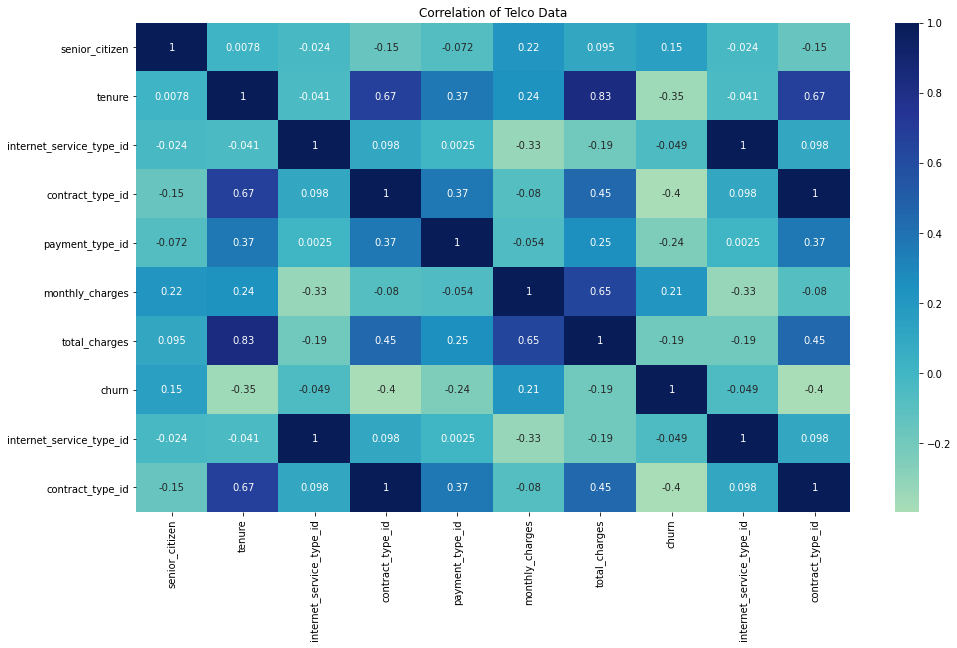

In [82]:
#heatmap to show correlation of all data
plt.figure(figsize=(16,9))

sns.heatmap(train.corr(), cmap='YlGnBu', center=0, annot=True)

plt.title('Correlation of Telco Data')

plt.show()

In [85]:
#find out how many customers churn vs how many do not churn
df.churn.value_counts()

#this shows that (26.54%) of ALL customers DO churn (1869 out of 7043) 

0    5174
1    1869
Name: churn, dtype: int64

In [83]:
#find out how many customers churn vs how many do not churn
train.churn.value_counts()

#this shows that (26.88%) of customers in the train dataset DO churn (1060 out of 3943) 

0    2883
1    1060
Name: churn, dtype: int64

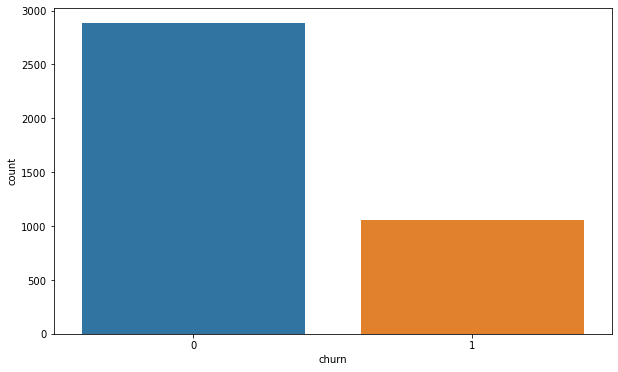

In [84]:
#visualize churn data using a countplot
plt.figure(figsize=(10,6))
sns.countplot(x='churn', data=train)
plt.show()

In [21]:
#average monthly charges, max monthly charges, min monthly charges
df.monthly_charges.mean(), df.monthly_charges.max(), df.monthly_charges.min()

(64.76169246059882, 118.75, 18.25)

In [87]:
#only using TRAIN data average monthly charges, max monthly charges, min monthly charges
train.monthly_charges.mean(), train.monthly_charges.max(), train.monthly_charges.min()

(64.61359371037278, 118.65, 18.55)

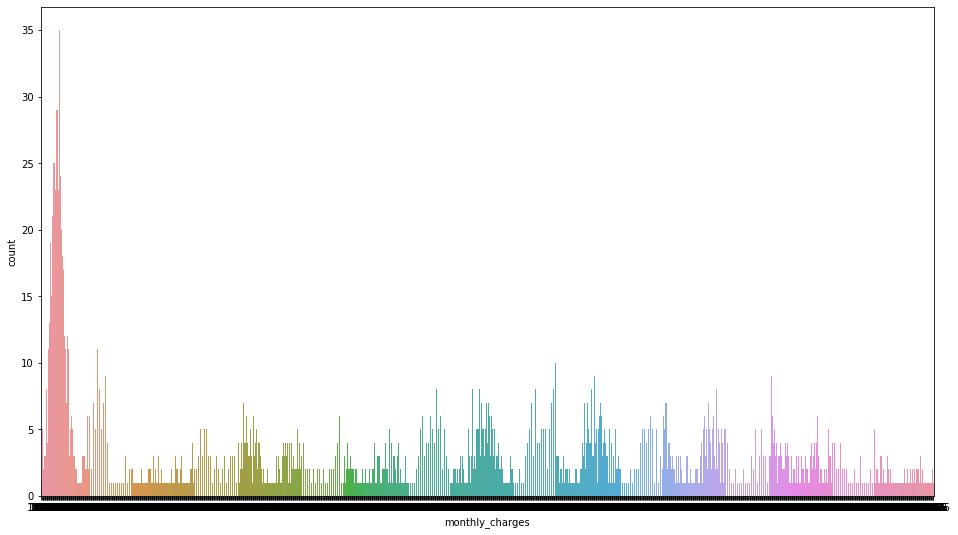

In [86]:
#visualize monthly charge data
plt.figure(figsize=(16,9))
sns.countplot(x='monthly_charges', data=train)
plt.show()

In [23]:
#find out how many are senior citizens and how many are not
df.senior_citizen.value_counts()

#this shows that 16.21% of all customers are seniors (1142 out of 7043)

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [88]:
#find out how many are senior citizens and how many are not
train.senior_citizen.value_counts()

#this shows that 16.21% of customers in the train dataset are seniors (639 out of 3943)

0    3304
1     639
Name: senior_citizen, dtype: int64

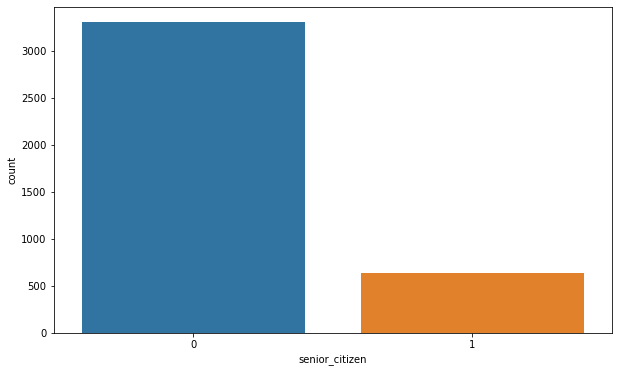

In [89]:
#visualize senior_citizen data using countplot
plt.figure(figsize=(10,6))
sns.countplot(x='senior_citizen', data=train)
plt.show()

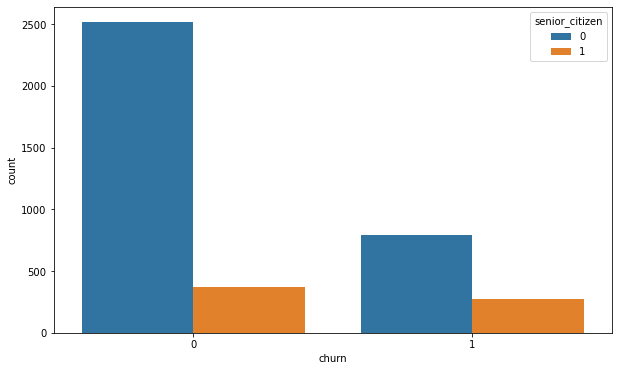

In [90]:
#this plot shows senior citizen (1) vs non-senior citizen (0)
## who churn (1) vs do not churn (0)
plt.figure(figsize=(10,6))
sns.countplot(x='churn', hue='senior_citizen', data=train)
plt.show()

In [26]:
#took at look at tenure out of curiosity
#average tenure, max tenure, min tenure??
df.tenure.mean(), df.tenure.max(), df.tenure.min()

(32.37114865824223, 72, 0)

In [91]:
#average tenure, max tenure, min tenure??
train.tenure.mean(), train.tenure.max(), train.tenure.min()

(32.22926705554146, 72, 0)

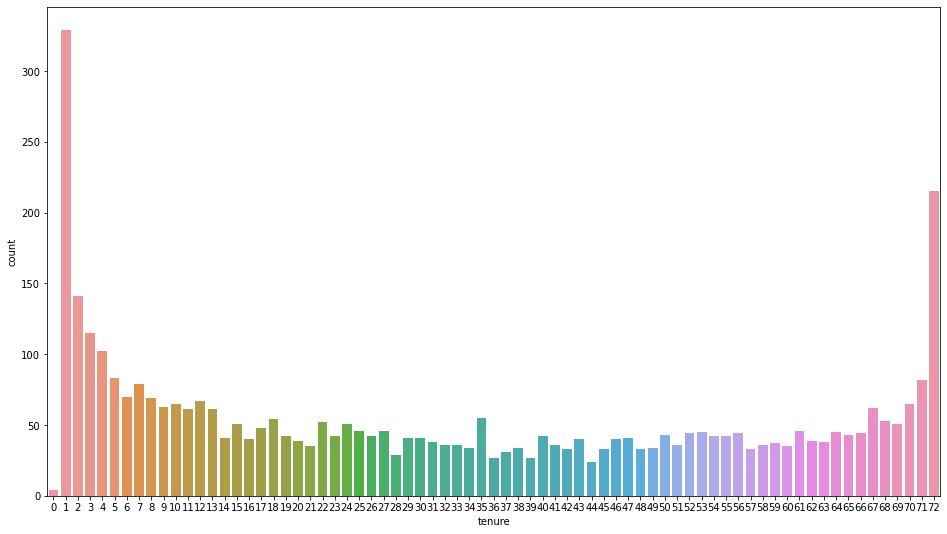

In [92]:
#visualize tenure data
plt.figure(figsize=(16,9))
sns.countplot(x='tenure', data=train)
plt.show()

In [93]:
#find the actual count for the top 5 tenures
tenure_df = train['tenure'].value_counts().sort_values(ascending=False).head()
tenure_df

#this shows that 8.34% of all customers only have ONE month of tenure (329 out of 3943)

1     329
72    215
2     141
3     115
4     102
Name: tenure, dtype: int64

In [95]:
#find the actual count for the top 5 monthly_chages
monthly_charges_df = train['monthly_charges'].value_counts().sort_values(ascending=False)
monthly_charges_df


20.05    35
19.85    29
19.90    29
19.95    27
20.25    26
         ..
56.65     1
64.55     1
52.20     1
77.85     1
51.65     1
Name: monthly_charges, Length: 1335, dtype: int64

## Takeaways of the Explore process:

- 7043 total customers
    - of those: 
        - 5901 are NOT senior_citizen (83.79%) while 1142 ARE senior_citizen (16.21%)
        - 5174 do NOT churn (73.46%) while 1869 DO churn (26.54%)
- Positive Correlation between churn is strongest between 'monthly_charges' and 'senior_citizen'
    - 'senior_citizen' is what interests me most to further explore/test


_______________

### Now.. I will find the appropriate statistical test to use
- we are using the two following variables: churn (discrete/categorical) and senior_citizen (discrete/categorical)
- these are 2 discrete/categorical variables
<br>

- **Therefore, I will be using $\chi^2$ testing**

In [30]:
#create confusion matrix
observed = pd.crosstab(df.churn, df.senior_citizen)
observed

senior_citizen,0,1
churn,,
0,4508,666
1,1393,476


In [31]:
#set alpha
alpha = 0.05

In [32]:
#chi2 contingency returns 4 different values
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(159.42630036838742,
 1.510066805092378e-36,
 1,
 array([[4335.05239245,  838.94760755],
        [1565.94760755,  303.05239245]]))

In [33]:
## make it easier to read
print('Observed\n')
print(observed.values)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[4508  666]
 [1393  476]]
---------------------
Expected

[[4335  838]
 [1565  303]]
---------------------

chi^2 = 159.4263
p     = 0.0000


## Hypothosis:

- **$H_{0}$**: there is no relationship between churn and customer age
<br>

- **$H_{a}$**: there is a relationshp between churn and customer age
<br>


- **True Positive**: I predict there is a relationship between churn and customer age and there is a relationship
<br>

- **True Negative**:I predict there is no relationship between churn and customer age and there is not relationship
<br>

- **False Positive**: I predict there is a relationship between churn and customer age and there is no relationship
<br>

- **False Negative**: I predict there is no relationship between churn and customer age and there is a relationship

## Further takeaways of the Explore process:

- $\chi^2$  test was used because we were dealing with two discrete variable (churn and senior_citizen)


In [105]:
print(f'The p-value is less than the alpha: {p < alpha}')

if p< alpha:
    print('Conclusion: We reject the null hypothesis')
else:
    print('Conclusion: We fail to reject the null hypothesis')

if p< alpha:
    print('Takeaways: There is a relationship between customer age and churn')
else:
    print('Takeaways: There is no relationship between customer age and churn')

The p-value is less than the alpha: True
Conclusion: We reject the null hypothesis
Takeaways: There is a relationship between customer age and churn


<hr style="border:2px solid black"> </hr>

# Model and Evaluate

Plan --- Acquire --- Prepare --- Explore --- **Model** --- Deliver

In [35]:
#we've already split the data in previous steps
#train, test = train_test_split(df, test_size=.2, random_state=123)
#train, validate = train_test_split(train, test_size=.3, random_state=123)

In [41]:
#get value count to determine what baseline will be equal to
train.churn.value_counts()

0    2883
1    1060
Name: churn, dtype: int64

In [42]:
#create baseline
#because the majority (in value count) was '0', we will use this as our baseline
train['baseline_pred'] = 0

In [43]:
##print statement for accuracy of baseline
baseline_accuracy = (train.churn == train.baseline_pred).mean()
print(f'The baseline accuracy is: {baseline_accuracy:.2%}')

The baseline accuracy is: 73.12%


## MVP Models
- I'm going to try Logistic Regression, DecisionTree, and RandomForest Models with
    - 'senior_citizen'
    - 'tenure'
    - 'monthly_charges'
- My goal is to beat my 73.12% baseline accuracy.
- Hyperparameters I've adjusted are:
    - setting the max_depth for the DecisionTree model to max_depth=5 to avoid overfitting
    - setting the.max_depth for the Random Forest Model to max_depth=10 to avoid overfitting
    - setting the random_state=123 for DecistionTree, RandomForest, and LogisticRegression models.

In [106]:
#specify columns to use
X_col= ['senior_citizen','tenure', 'monthly_charges']
y_col= 'churn'

In [107]:
#specify train, validate, test
X_train = train[X_col]
y_train= train[y_col]

X_validate = validate[X_col]
y_validate= validate[y_col]

X_test = test[X_col]
y_test= test[y_col]

In [108]:
#get shape of sets
train.shape, validate.shape, test.shape

((3943, 26), (1691, 26), (1409, 26))

In [109]:
#shape of train set
X_train.shape, y_train.shape

((3943, 3), (3943,))

In [110]:
#take a look at X_train data
X_train.head()

,senior_citizen,tenure,monthly_charges
4604,1,1,75.30
5566,0,71,19.10
6204,0,19,19.80
5837,0,56,24.15
1276,1,13,45.30


_______________________

# Evaluate MVP Models

## Logistic Regression Model 

In [44]:
#import
from sklearn.linear_model import LogisticRegression

In [45]:
#Define the logistic regression model
logit_model = LogisticRegression(C=0.1, random_state= 123)

In [46]:
#fit the model with train data 
logit_model.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=123)

In [47]:
#now use the model to make predictions
y_pred = logit_model.predict(X_train)

In [48]:
#classifcation report
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.826101,0.650127,0.791022,0.738114,0.778794
recall,0.904613,0.482075,0.791022,0.693344,0.791022
f1-score,0.863576,0.553629,0.791022,0.708603,0.780253
support,2883.000000,1060.000000,0.791022,3943.000000,3943.000000


In [49]:
#import function created to give score, rates, confusion matrix, and classification report
import model_func

In [50]:
model_func.model_performs(X_train, y_train, logit_model)


    The accuracy for our model is 79.1022%
    The True Positive Rate is 48.208%,    The False Positive Rate is 9.539%,
    The True Negative Rate is 90.461%,    The False Negative Rate is 51.792%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 2608,False positive: 275
actual_churned,False Negative: 549,True Positive: 511



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.826101,0.904613,0.863576,2883.000000
churned,0.650127,0.482075,0.553629,1060.000000
accuracy,0.791022,0.791022,0.791022,0.791022
macro avg,0.738114,0.693344,0.708603,3943.000000
weighted avg,0.778794,0.791022,0.780253,3943.000000


In [51]:
model_func.model_performs(X_validate, y_validate, logit_model)


    The accuracy for our model is 78.8291%
    The True Positive Rate is 46.444%,    The False Positive Rate is 9.428%,
    The True Negative Rate is 90.572%,    The False Negative Rate is 53.556%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 1124,False positive: 117
actual_churned,False Negative: 241,True Positive: 209



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.823443,0.905721,0.862625,1241.000000
churned,0.641104,0.464444,0.538660,450.000000
accuracy,0.788291,0.788291,0.788291,0.788291
macro avg,0.732274,0.685083,0.700642,1691.000000
weighted avg,0.774920,0.788291,0.776413,1691.000000


### Logistic Regression Model Takeaways: 

- Logistic Regression Model has an accuracy of 79.10% using the train set
- Logistic Regression Model has an accuracy of 78.83% using the validate set
- Both are **higher** than the baseline accuracy of 73.12% 
    

___________

## Random Forest Model

In [52]:
#import
from sklearn.ensemble import RandomForestClassifier

In [53]:
#make our thing
rf_model= RandomForestClassifier(min_samples_leaf = 1, max_depth = 10, random_state= 123)

In [54]:
#fit the thing (ONLY on train set!!)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [55]:
#use the thing
#train data set score, confusion matrix and classification report
model_func.model_performs(X_train, y_train, rf_model)


    The accuracy for our model is 87.2939%
    The True Positive Rate is 66.981%,    The False Positive Rate is 5.238%,
    The True Negative Rate is 94.762%,    The False Negative Rate is 33.019%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 2732,False positive: 151
actual_churned,False Negative: 350,True Positive: 710



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.886437,0.947624,0.916010,2883.000000
churned,0.824623,0.669811,0.739198,1060.000000
accuracy,0.872939,0.872939,0.872939,0.872939
macro avg,0.855530,0.808718,0.827604,3943.000000
weighted avg,0.869820,0.872939,0.868478,3943.000000


In [56]:
#use the thing
#validate data set score, confusion matrix and classification report
model_func.model_performs(X_validate, y_validate, rf_model)


    The accuracy for our model is 78.1195%
    The True Positive Rate is 46.889%,    The False Positive Rate is 10.556%,
    The True Negative Rate is 89.444%,    The False Negative Rate is 53.111%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 1110,False positive: 131
actual_churned,False Negative: 239,True Positive: 211



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.822832,0.894440,0.857143,1241.000000
churned,0.616959,0.468889,0.532828,450.000000
accuracy,0.781195,0.781195,0.781195,0.781195
macro avg,0.719895,0.681664,0.694986,1691.000000
weighted avg,0.768046,0.781195,0.770838,1691.000000


### Random Forest Model Takeaways: 

- Random Forest Model has an accuracy of 87.29% using the train set
- Random Forest Model has an accuracy of 78.12% using the validate set
- Both are **higher** than the baseline accuracy of 73.12% 
- **but** there is *too much* difference between train and validate set (too overfit)


___________________

## Decision Tree Model

In [57]:
#create model
dt_model = DecisionTreeClassifier(max_depth=5)

In [58]:
#fit model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [59]:
#use the thing
#train data set score, confusion matrix and classification report
model_func.model_performs(X_train, y_train, dt_model)


    The accuracy for our model is 79.6855%
    The True Positive Rate is 55.283%,    The False Positive Rate is 11.342%,
    The True Negative Rate is 88.658%,    The False Negative Rate is 44.717%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 2556,False positive: 327
actual_churned,False Negative: 474,True Positive: 586



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.843564,0.886576,0.864536,2883.000000
churned,0.641840,0.552830,0.594019,1060.000000
accuracy,0.796855,0.796855,0.796855,0.796855
macro avg,0.742702,0.719703,0.729278,3943.000000
weighted avg,0.789335,0.796855,0.791813,3943.000000


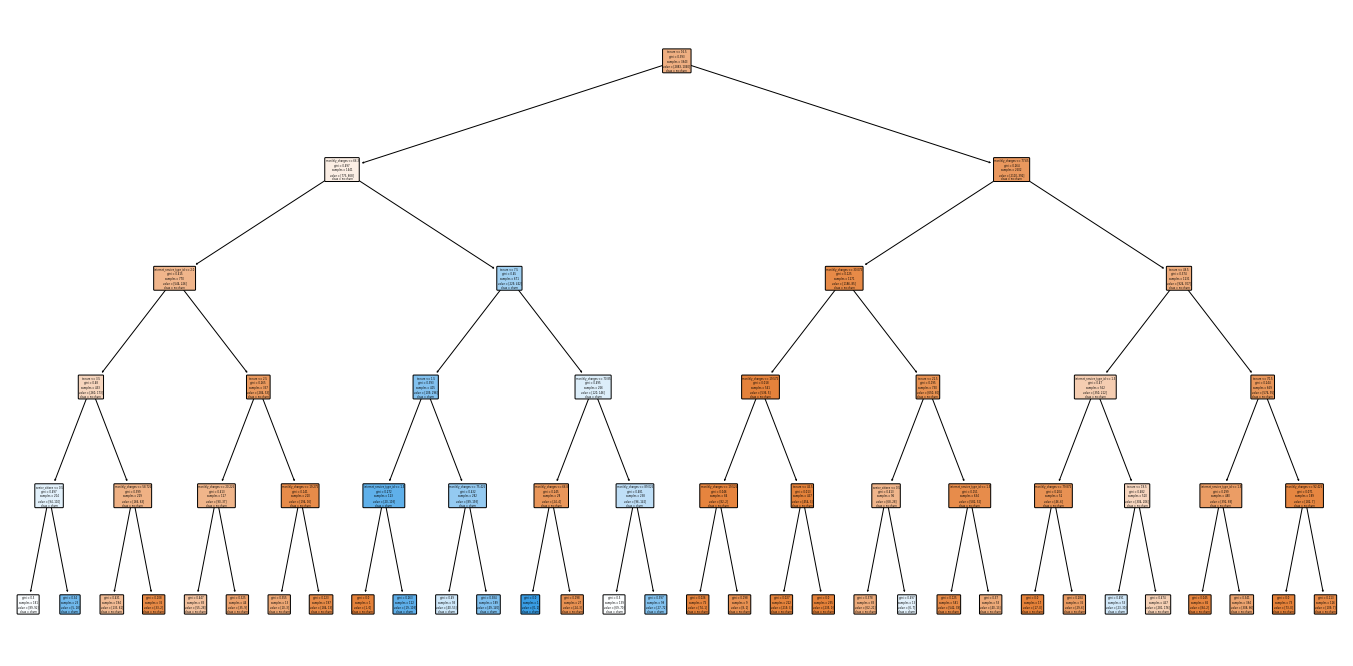

In [60]:
#visualize train set
plt.figure(figsize=(24,12))

plot_tree(dt_model, feature_names=X_train.columns.tolist(), filled=True, rounded=True, class_names=['no churn', 'churn'])
plt.show()

In [61]:
#use the thing
#validate data set score, confusion matrix and classification report
model_func.model_performs(X_validate, y_validate, dt_model)


    The accuracy for our model is 78.3560%
    The True Positive Rate is 52.667%,    The False Positive Rate is 12.329%,
    The True Negative Rate is 87.671%,    The False Negative Rate is 47.333%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 1088,False positive: 153
actual_churned,False Negative: 213,True Positive: 237



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.836280,0.876712,0.856019,1241.00000
churned,0.607692,0.526667,0.564286,450.00000
accuracy,0.783560,0.783560,0.783560,0.78356
macro avg,0.721986,0.701689,0.710152,1691.00000
weighted avg,0.775449,0.783560,0.778384,1691.00000


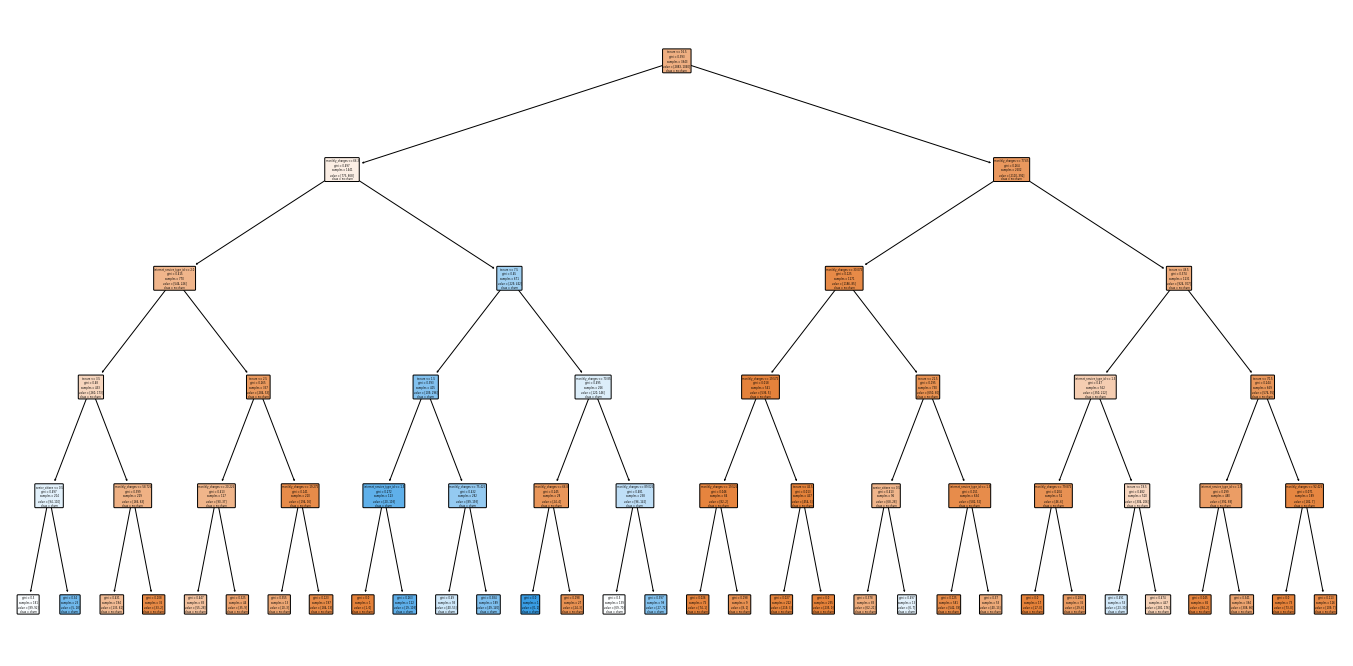

In [62]:
#visualize validate set
plt.figure(figsize=(24,12))

plot_tree(dt_model, feature_names=X_validate.columns.tolist(), filled=True, rounded=True, class_names=['no churn', 'churn'])
plt.show()

### Decision Tree Model Takeaways: 

- Decision Tree Model has an accuracy of 79.36% using the train set using max_depth=5
- Decision Tree Model has an accuracy of 78.95% using the validate set using max_depth=5
- Both are **higher** than the baseline accuracy of 73.12% 


### Run Decision Tree Model on Test Dataset

In [63]:
#use the thing
#train data set score, confusion matrix and classification report
model_func.model_performs(X_test, y_test, dt_model)


    The accuracy for our model is 78.7083%
    The True Positive Rate is 48.468%,    The False Positive Rate is 10.952%,
    The True Negative Rate is 89.048%,    The False Negative Rate is 51.532%
    ________________________________________________________________________________
    

    The positive is  'churned'
    Confusion Matrix
    


,pred_didint_churn,pred_churned
actual_didnt_churn,True Negative: 935,False positive: 115
actual_churned,False Negative: 185,True Positive: 174



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
didnt churn,0.834821,0.890476,0.861751,1050.000000
churned,0.602076,0.484680,0.537037,359.000000
accuracy,0.787083,0.787083,0.787083,0.787083
macro avg,0.718449,0.687578,0.699394,1409.000000
weighted avg,0.775520,0.787083,0.779017,1409.000000


### Decision Tree Model with Test Dataset: 

- Decision Tree Model has an accuracy of 78.70% using the train set using max_depth=5
- Both are **higher** than the baseline accuracy of 73.12% 


<hr style="border:2px solid black"> </hr>

## Create CSV for Predictions

In [64]:
import prepare

In [65]:
df_all_data = prepare.prep_telco_churn(acquire.get_telco_churn_data())

In [66]:
#create column that has prediction based on decision tree model
df_all_data ['predictions'] = dt_model.predict(df_all_data[X_col])

In [67]:
#create dataframe that shows if that particular customer_id will churn of not
df_predictions = df_all_data[['customer_id', 'predictions']]

In [68]:
#take a look at this prediction data
df_predictions.head()

,customer_id,predictions
0,0016-QLJIS,0
1,0017-DINOC,0
2,0019-GFNTW,0
3,0056-EPFBG,0
4,0078-XZMHT,0


In [70]:
df_predictions.predictions.value_counts()
# based on predictions, we have 1592 customers who have the potential to churn!!

0    5451
1    1592
Name: predictions, dtype: int64

In [69]:
#turn this new dataframe of customer_id and predictions into a CSV file
df_predictions.to_csv('telco_churn_predictions.csv')

<hr style="border:2px solid black"> </hr>

## Conclusion/Final Takeaway:
- Overall, the decision tree model performed best

    - there is acceptable accuracy on both the train set and the validate set
    - the score is higher than the baseline
    - there is not a large drop off of accuracy between the two sets (thus it is not overfit)

<br>
- Use the new dataframe of predictions to target those specific customers that have the most potential to churn

<hr style="border:2px solid black"> </hr>

## Next Steps/If I had more time:
- I would run more models and change the hyperparameters on several different versions
- I would look into adding surveying to exiting customers to further understand their actual cause of churn
- We can then target the true reason to reduce churn in future customers
